## Sparse Bayesian learning: Original algorithm

###### Assumptions: polynomial basis functions, scalar output, scalar input
###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
random.seed(106) # fixing the random seed

#### Problem definition

In [2]:
polyPower = [0,1,2,3,4,5] # powers of polynomial
hypPar = 1e-05
N = len(polyPower) # number of basis
alpha0 = np.exp([5]*N) # Starting hyper-parameter value 
def basisFun(Xth,ith):
    return Xth**polyPower[ith]
rho0 = 100 # Starting error precision
rTol = 0.1 # 0-1,below this implies irrelevance
a = 1+rho0**2/1e-01 # prior for rho ~ gamma(a,b), 1 is added to ensure a>1
b = rho0/1e-01 # mean=a/b, var=a/b**2
c = 1.0+hypPar # prior for hyperparameter alpha gamma(c,d), between 1-2
d = hypPar # +ve and close to zero, decides the maximum attainable value for alpha
Nsbl = 355 # number of SBL iterations (add 5 always)
SBLapproach = 2 # there are two ways to update alpha
trueKnown = 1 # 0 = dont plot true, 1= plot true 
CoeffTrue =[0]*N
CoeffTrue[0]=1
CoeffTrue[2]=1 
rhoTrue = 100

#### Load observations and generate design matrix

In [3]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = basisFun(Xobs[i],j)

#### Bayesian linear regression routine

In [4]:
def updateStat(alphai,rhoi):
    Ainv = np.diag(1.0/alphai)
    Bi = np.matmul(Phi,np.matmul(Ainv,np.transpose(Phi))) + np.identity(M)/rhoi
    Binvi = la.inv(Bi)
    Ki = np.matmul(Ainv,np.matmul(np.transpose(Phi),Binvi))
    Pi = Ainv - np.matmul(Ki,np.matmul(Phi,Ainv))
    mi = np.matmul(Ki,Yobs)
    PMLEinvi = rhoi*np.matmul(np.transpose(Phi),Phi)
    logEvidi = np.log(st.multivariate_normal.pdf(Yobs,[0]*M,Bi))
    gofi = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,mi),np.identity(M)/rhoi) - 0.5*np.trace(np.matmul(PMLEinvi,Pi))
    return mi, Pi, logEvidi, gofi

#### SBL original algorithm

In [5]:
alpha = np.zeros((N,Nsbl)); r = np.zeros((N,Nsbl))
Wvar = np.zeros((N,Nsbl));  m = np.zeros((N,Nsbl))
KLdiv = np.zeros((N,Nsbl)); P = np.zeros((N,N))
logEvid = [0]*Nsbl; gof = [0]*Nsbl; objFun = [0]*Nsbl
rho = [0]*Nsbl; sparsity = [0]*N
alpha[:,0] = alpha0;
rho[0] = rho0;
curList = list(range(N))

In [6]:
for j in range(0,Nsbl-1):
    alpha[:,j+1] = alpha[:,j]
    m[:,j],P,logEvid[j],gof[j] = updateStat(alpha[:,j],rho[j])
    Wvar[:,j] = np.diag(P)
    for ii in range(0,N):
        r[ii,j]   = 1-alpha[ii,j]*Wvar[ii,j] 
        KLdiv[ii,j] = 0.5*(-np.log(alpha[ii,j]*Wvar[ii,j])- 1 + alpha[ii,j]*(Wvar[ii,j] + m[ii,j]**2))
        if r[ii,j] > rTol: sparsity[ii] = 1
        else:              sparsity[ii] = 0
    i=j%N
    #if i == 0:  np.random.shuffle(curList) # if selecting the basis randomly each time
    curi = curList[i]
    if SBLapproach == 1:
        alpha[curi,j+1] = (1+2*(c-1))/(Wvar[curi,j] + m[curi,j]**2+2*d)
        rho[j+1] = (M+2*(a-1))/(np.power(la.norm(Yobs-np.matmul(Phi,m[:,j])),2)\
                            +np.trace(np.matmul(P,np.matmul(np.transpose(Phi),Phi)))+2*b)
    elif SBLapproach == 2:
        alpha[curi,j+1] = (r[curi,j]+2*(c-1))/(m[curi,j]**2+2*d)
        rho[j+1] = (M-np.sum(r[:,j])+2*(a-1))/(np.power(la.norm(np.subtract(Yobs,np.matmul(Phi,m[:,j]))),2)+2*b)
    objFun[j] = logEvid[j] + (c-1.0)*np.sum(np.log(alpha[:,j])) - d*np.sum(alpha[:,j])
np.savetxt('SBLorig_feval.dat',np.asarray(objFun[:-1]))

In [7]:
print(' i     mean      var         prec      alpha    logalpha      r       KLdiv    Sparse?')
for i in range(0,N):
    print("{0:2d}{1:11.3e}{2:11.3e}{3:11.3e}{4:11.3e}{5:10.3f}{6:11.3e}{7:11.3e}{8:5d}".format(\
        int(i),m[i,-2],Wvar[i,-2],1/Wvar[i,-2],alpha[i,-2],np.log(alpha[i,-2]),r[i,-2],KLdiv[i,-2],sparsity[i]))
print("\nLogEvid : {0:9.2f}\nRho: {1:14.3e}\nSparsity: {2:3d}/{3:3d}".format(\
    logEvid[-2],rho[-2],int(sum(sparsity)),N))
print(objFun[0],np.log(alpha[:,0]))
print(objFun[-2])

 i     mean      var         prec      alpha    logalpha      r       KLdiv    Sparse?
 0  9.743e-01  2.259e-03  4.426e+02  1.051e+00     0.050  9.976e-01  3.022e+00    1
 1  3.903e-01  2.403e-02  4.162e+01  5.669e+00     1.735  8.638e-01  9.967e-01    1
 2  8.561e-03  6.464e-03  1.547e+02  1.525e+02     5.027  1.422e-02  5.639e-03    0
 3  6.914e-01  3.925e-02  2.548e+01  1.933e+00     0.659  9.241e-01  1.289e+00    1
 4  9.279e-03  5.493e-03  1.821e+02  1.786e+02     5.185  1.893e-02  7.779e-03    0
 5  4.805e-03  2.577e-03  3.880e+02  3.816e+02     5.944  1.642e-02  4.474e-03    0
 6  3.100e-03  1.714e-03  5.836e+02  5.737e+02     6.352  1.697e-02  2.830e-03    0
 7  2.073e-03  1.326e-03  7.544e+02  7.408e+02     6.608  1.798e-02  1.674e-03    0

LogEvid :     13.47
Rho:      1.000e+02
Sparsity:   3/  8
-66.79020240845043 [5. 5. 5. 5. 5. 5. 5. 5.]
13.448283400747872


#### Plot statistics over SBL iteration

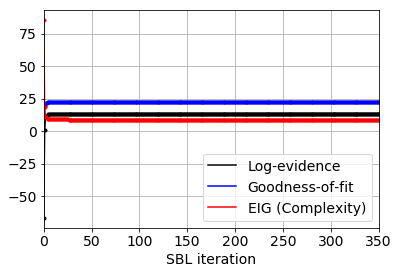

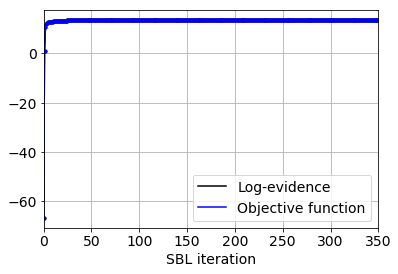

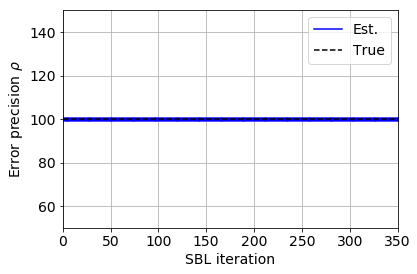

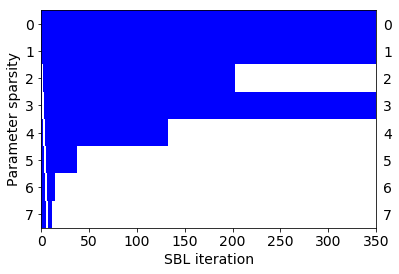

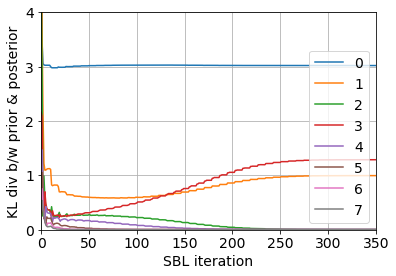

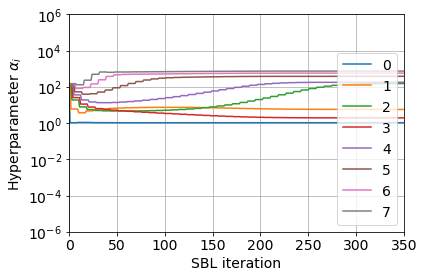

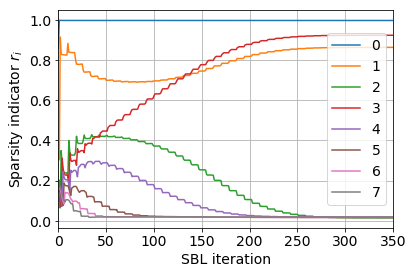

In [8]:
mpl.rcParams.update({'font.size':14})
plt.figure(1)
plt.plot(logEvid[:-1],'k.')
plt.plot(logEvid[:-1],'k-',label='Log-evidence')
plt.plot(np.log(gof[:-1]),'b.')
plt.plot(np.log(gof[:-1]),'b-',label='Goodness-of-fit')
plt.plot(np.log(gof[:-1]) - logEvid[:-1],'r.')
plt.plot(np.log(gof[:-1]) - logEvid[:-1],'r-',label='EIG (Complexity)')
#plt.legend(loc='best', numpoints = 1)
plt.legend(loc='lower right', numpoints = 1)
plt.grid(True)
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('figs/4_SBLorig_stat.eps',bbox_inches='tight')
mpl.rcParams.update({'font.size':14})
plt.figure(51)
plt.plot(logEvid[:-1],'k.')
plt.plot(logEvid[:-1],'k-',label='Log-evidence')
plt.plot(objFun[:-1],'b.')
plt.plot(objFun[:-1],'b-',label='Objective function')
#plt.legend(loc='best', numpoints = 1)
plt.legend(loc='lower right', numpoints = 1)
plt.grid(True)
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('figs/4_SBLorig_stat2.eps',bbox_inches='tight')
plt.figure(2)
plt.plot(rho[:-1],'b.')
plt.plot(rho[:-1],'b-',label='Est.')
plt.plot([0,Nsbl],[rhoTrue,rhoTrue],'k--',label='True')
plt.legend(loc='best', numpoints = 1); plt.grid(True)
plt.xlim([0,Nsbl-5])
plt.ylim([rhoTrue-50,rhoTrue+50])
plt.ylabel(r'Error precision $\rho$')
plt.xlabel('SBL iteration');
plt.savefig('figs/4_SBLorig_rho.eps',bbox_inches='tight')
fig, ax = plt.subplots()
cmap = mpl.colors.ListedColormap(['white', 'blue'])
bounds = [0,rTol,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(r, cmap=cmap, aspect='auto',norm=norm)
ax.tick_params(labelright=True)
ax.set_yticks(np.arange(0, N, 1))
plt.xlim([0,Nsbl-5])
plt.ylabel('Parameter sparsity')
plt.xlabel('SBL iteration')
plt.savefig('figs/4_SBLorig_sparsity.eps',bbox_inches='tight')
plt.figure(4)
for i in range(0,N):
    plt.plot(KLdiv[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel('KL div b/w prior & posterior')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.ylim([0,4])
plt.legend(loc='lower right', numpoints = 1)
plt.savefig('figs/4_SBLorig_kldiv.eps',bbox_inches='tight')
plt.figure(7)
for i in range(0,N):
    plt.semilogy(alpha[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel(r'Hyperparameter $\alpha_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.ylim(np.power(10.0,[-6,6]))
plt.legend(loc='lower right', numpoints = 1)
plt.savefig('figs/4_SBLorig_alpha.eps',bbox_inches='tight')
plt.figure(8)
for i in range(0,N):
    plt.plot(r[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel(r'Sparsity indicator $r_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='center right', numpoints = 1)
plt.savefig('figs/4_SBLorig_r.eps',bbox_inches='tight')

#### Plot parameter marginal pdfs

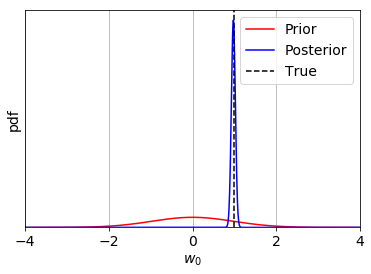

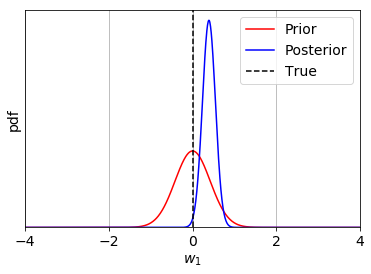

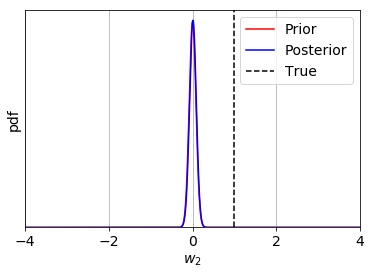

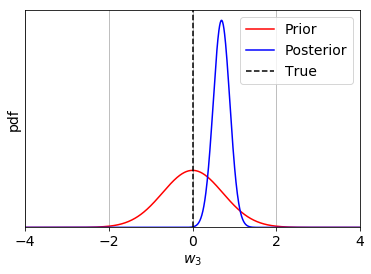

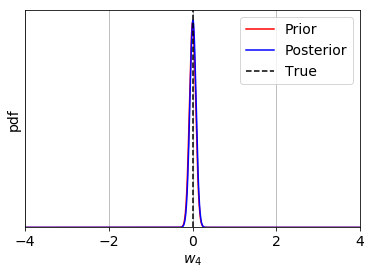

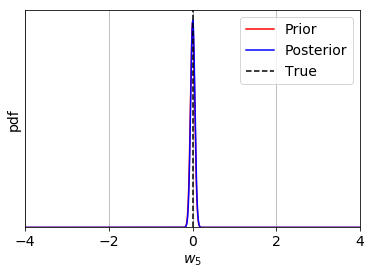

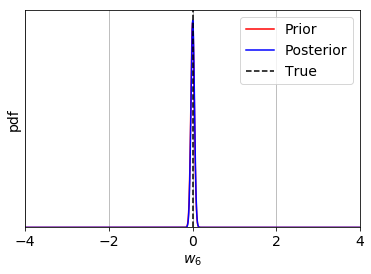

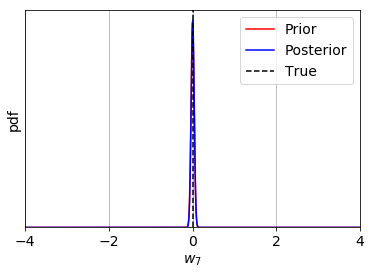

In [9]:
mpl.rcParams.update({'font.size':14})
Wlim = [-4,4]  # xlim for plotting pdf plots
Ngrid = 1000  # density for grid generation in X
pscale=5  # for automatic bound calculation for pdf plots 
for i in range(0,N):
    Wpriormin = -pscale*np.sqrt(1/alpha[i,-2])
    Wpriormax = pscale*np.sqrt(1/alpha[i,-2])
    Wpostmin = m[i,-2]-pscale*np.sqrt(Wvar[i,-2])
    Wpostmax = m[i,-2]+pscale*np.sqrt(Wvar[i,-2])
    # comment this if using user supplied bounds Wlim
    #Wlim = [min(Wpriormin,Wpostmin),max(Wpostmax,Wpriormax)] 
    Wgrid  = np.linspace(Wlim[0],Wlim[1],Ngrid)
    Wpost  = st.multivariate_normal.pdf(Wgrid,m[i,-2],Wvar[i,-2])
    Wprior = st.multivariate_normal.pdf(Wgrid,0,1/alpha[i,-2])
    fig = plt.figure(i+8)
    plt.plot(Wgrid,Wprior,'r-',label='Prior')
    plt.plot(Wgrid,Wpost,'b-',label='Posterior')
    plt.grid(True)
    plt.yticks([])
    ax = plt.gca(); Ylim = ax.get_ylim()
    if trueKnown == 1: plt.plot([CoeffTrue[i],CoeffTrue[i]],[0,Ylim[1]],'k--',label='True')
    plt.ylim([0,Ylim[1]])
    plt.xlabel(r'$w_{'+str(i)+'}$')
    plt.ylabel('pdf')
    plt.xlim(Wlim[0],Wlim[1])
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('figs/4_SBLorig_mpdf'+str(i)+'.eps',bbox_inches='tight')

#### Plot model predictions vs true response

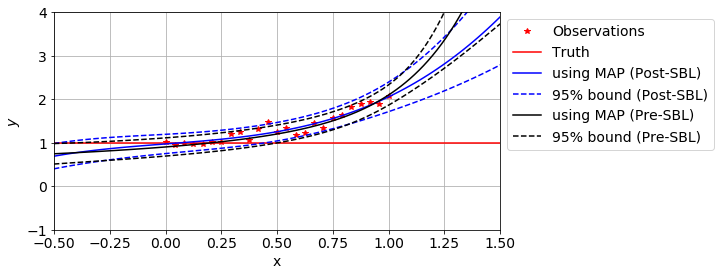

In [10]:
Xextra = 0.501 # width for extrapolation
Yrnge = [-1,4] 
Mnew = 100
Xrnge = [min(Xobs)-Xextra,max(Xobs)+Xextra]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
PhiNew0 = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = sparsity[j]*basisFun(Xnew[i],j)
        PhiNew0[i,j] = basisFun(Xnew[i],j)
Yvar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho[-1]
Ymean = np.matmul(PhiNew,m[:,-2])
m0,P0,logEvid0,gof0 = updateStat(np.asarray(alpha0),rho0)
Yvar0 = np.matmul(PhiNew0,np.matmul(P0,np.transpose(PhiNew0))) + np.identity(Mnew)/rho0
Ymean0 = np.matmul(PhiNew0,m0)
fig = plt.figure(N+1,figsize=(8, 4))
ax = plt.subplot(111)
plt.plot(Xobs,Yobs,'r*',label='Observations')
if trueKnown ==1:
    Ytrue = np.matmul(PhiNew,np.transpose(CoeffTrue))
    plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.plot(Xnew,Ymean,'b-',label='using MAP (Post-SBL)')
plt.plot(Xnew,Ymean+2*np.sqrt(np.diag(Yvar)),'b--',label='95% bound (Post-SBL)')
plt.plot(Xnew,Ymean-2*np.sqrt(np.diag(Yvar)),'b--')
plt.plot(Xnew,Ymean0,'k-',label='using MAP (Pre-SBL)')
plt.plot(Xnew,Ymean0+2*np.sqrt(np.diag(Yvar0)),'k--',label='95% bound (Pre-SBL)')
plt.plot(Xnew,Ymean0-2*np.sqrt(np.diag(Yvar0)),'k--')
plt.grid(True)
plt.ylabel(r'$y$')
plt.xlabel('x')
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
ax.legend(bbox_to_anchor=(1, 1))
#plt.legend(loc='best', numpoints = 1)
plt.savefig('figs/4_SBLorig_pred.eps',bbox_inches='tight')

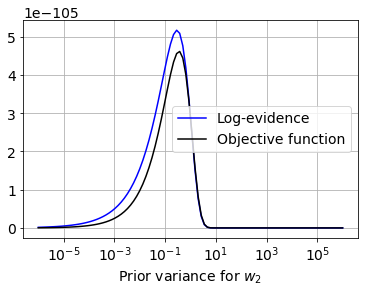

In [11]:
Niter = 100
alphatry = alpha[:,-2]
#alphatry = alpha0
alphatry =[1e+03]*N
indi = 2
c=1.10
alphaIter = np.logspace(-6,6,Niter)
logEvidIter = [0]*Niter
objFunIter = [0]*Niter
for i in range(0,Niter):
    alphatry[indi] = alphaIter[i]
    mtmp,Ptmp,logEvidIter[i],goftemp = updateStat(np.asarray(alphatry),rhoTrue)
    objFunIter[i] = logEvidIter[i] + (c-1)*np.log(alphatry[indi]) - d*alphatry[indi]
fig=plt.figure(21)
plt.semilogx(alphaIter,np.exp(logEvidIter),'b-',label='Log-evidence')
plt.semilogx(alphaIter,np.exp(objFunIter),'k-',label='Objective function')
plt.grid(True)
plt.legend(loc='best', numpoints = 1)
plt.xlabel(r'Prior variance for $w_'+str(indi)+'$')
plt.savefig('figs/4_SBLorig_1Dplot_'+str(indi)+'.eps',bbox_inches='tight')

#### Plot evidence vs alpha

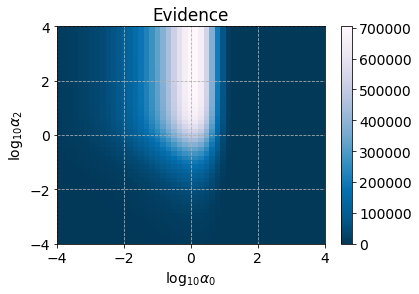

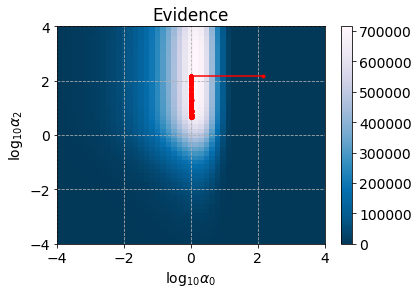

In [12]:
Niter = 50
alp = alpha[:,-2]
alpi1 = 0
alpi2 = 2
Pi1 = np.linspace(-4,4,Niter)
Pi2 = np.linspace(-4,4,Niter)
Pmsh = np.zeros((N*N,2))
P1,P2 = np.meshgrid(Pi1,Pi2)
logEvid = np.zeros((Niter,Niter))
objFun = np.zeros((Niter,Niter))
for i in range(0,Niter):
    for j in range(Niter):
        alp[alpi1] = np.power(10.0,P1[i,j])
        alp[alpi2] = np.power(10.0,P2[i,j])
        mtmp,Ptmp,logEvid[i,j],goftemp = updateStat(np.asarray(alp),rhoTrue)
        objFun[i,j] = logEvid[i,j] + (c-1)*np.log(alp[alpi1]) - d*alp[alpi2]
fig=plt.figure(31)
#plt.pcolor(P1,P2,reshape(Yord,(N,N)),cmap='RdBu',vmin=0.28,vmax=0.38)
#plt.pcolor(P1,P2,logEvid,cmap='PuBu_r')
plt.pcolor(P1,P2,np.exp(logEvid),cmap='PuBu_r')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log_{10}\alpha_{'+str(alpi1)+'}$')
plt.ylabel(r'$\log_{10}\alpha_{'+str(alpi2)+'}$')
plt.title('Evidence')
plt.savefig('figs/4_SBLorig_2Devid.eps',bbox_inches='tight')
fig=plt.figure(32)
plt.pcolor(P1,P2,np.exp(objFun),cmap='PuBu_r')
plt.colorbar()
plt.plot(np.log10(alpha[alpi1,:-2]),np.log10(alpha[alpi2,:-2]),'r.')
plt.plot(np.log10(alpha[alpi1,:-2]),np.log10(alpha[alpi2,:-2]),'r-')
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log_{10}\alpha_{'+str(alpi1)+'}$')
plt.ylabel(r'$\log_{10}\alpha_{'+str(alpi2)+'}$')
plt.title('Evidence')
plt.savefig('figs/4_SBLorig_2Dobjfun.eps',bbox_inches='tight')
#print(np.log10(alpha[:,-2]))